# X_velocity

In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train_surface import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/X_NACA0012.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])
    
surface_mask = train_dataset.surface_mask

linear_ae_input_size = torch.flatten(train_dataset[0].x).shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1]
model = GAE(config = config, ae_input_size = linear_ae_input_size).to(device)

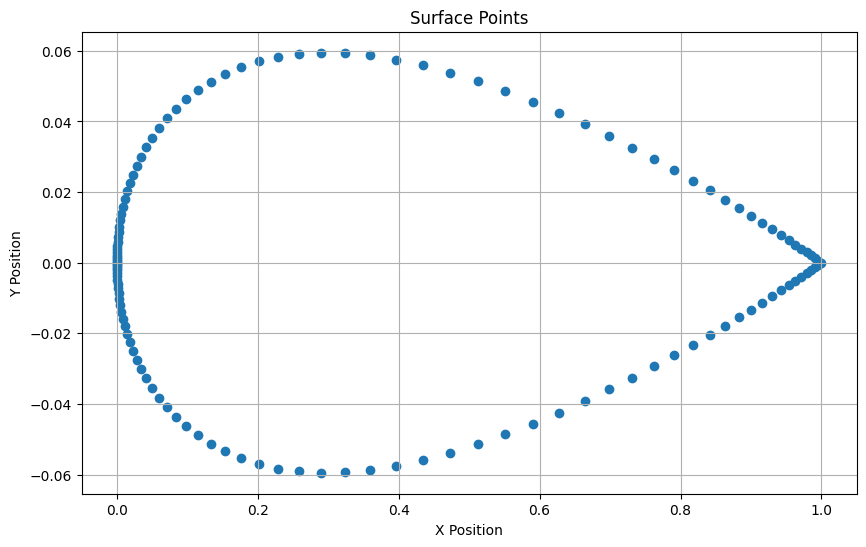

In [2]:
import matplotlib.pyplot as plt
surface_point = train_dataset[0].pos[surface_mask, :]
plt.figure(figsize=(10, 6))
plt.scatter(surface_point[:, 0].cpu().numpy(), surface_point[:, 1].cpu().numpy())
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Surface Points')
plt.grid(True)
plt.show()

## Training

In [3]:
history = train(model = model, 
                device = device, 
                surface_mask = surface_mask,
                lambda_surface=1,
                train_loader = train_loader, 
                is_val = True,
                val_loader = val_loader, 
                start_up_epoch=50,
                save_best_model=True,
                save_history=True,
                config = config['training'])

train_history, val_history = history


100%|██████████| 5000/5000 [6:57:51<00:00,  5.01s/it, train_loss=0.030543, map_loss=0.000874, reconstruction_loss=0.029669, val_loss=0.042088, val_reconstruction_loss=0.040772, val_map_loss=0.001317]  


In [4]:
from src.utils.commons import save_config
save_config(config, task='surface')

## Plot train total loss and val total loss

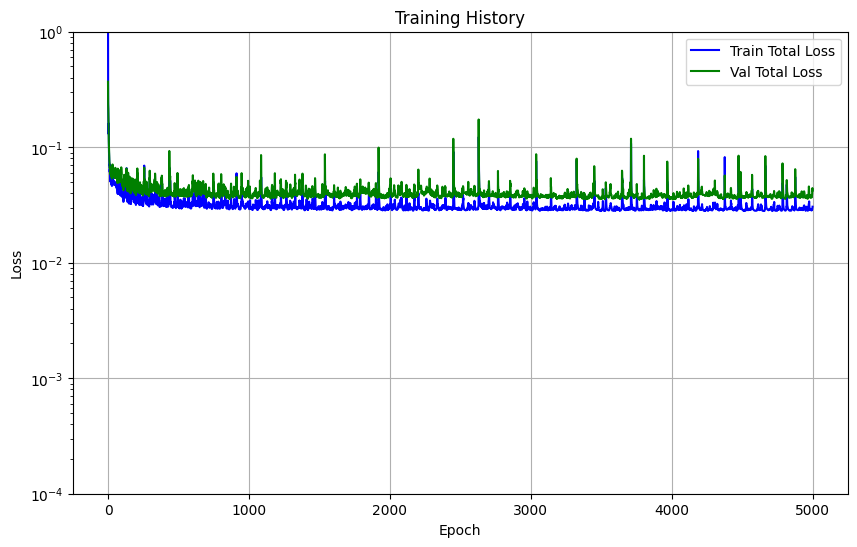

In [5]:
import pickle
import matplotlib.pyplot as plt
from src.utils.commons import get_config

config = get_config('configs/X_NACA0012.yaml')
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

with open(f"artifacts/surface/{model_name}/{model_name}_history_{num_epochs}.pkl", 'rb') as f:
    # Load the history dictionary
    train_history = pickle.load(f)
    val_history = pickle.load(f)
    
train_total_loss = train_history['train_loss']
val_total_loss = val_history['val_loss']    

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_total_loss, label='Val Total Loss', color='green')
plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot train loss history

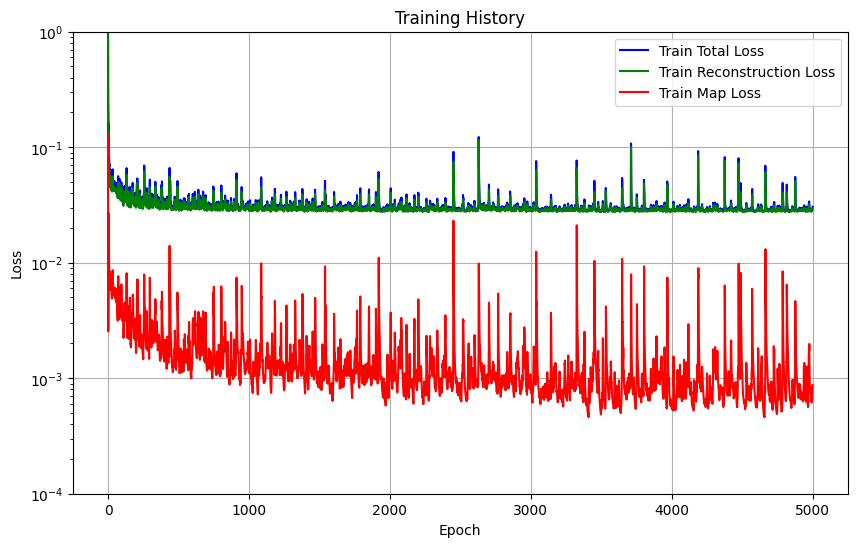

In [6]:
train_total_loss = train_history['train_loss']
train_reconstruction_loss = train_history['reconstruction_loss']
train_map_loss = train_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(train_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(train_map_loss, label='Train Map Loss', color='red')
plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot validation loss history

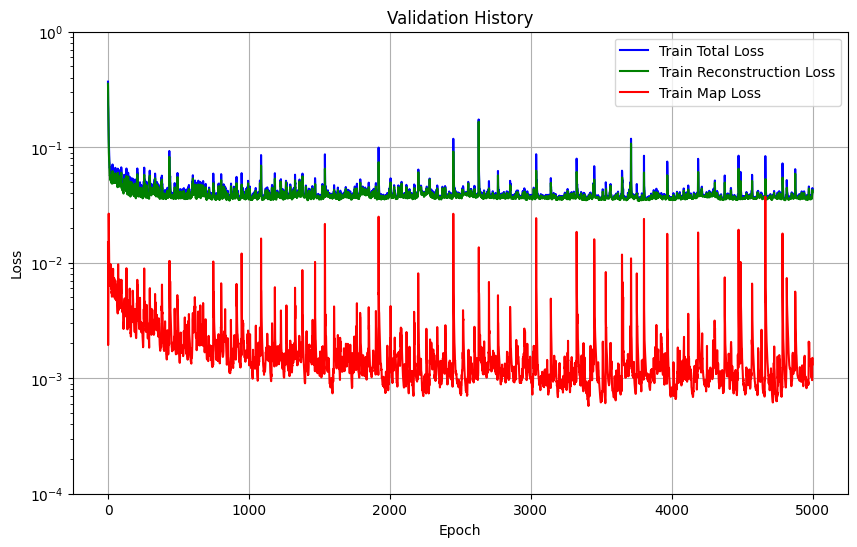

In [7]:
val_total_loss = val_history['val_loss']
val_reconstruction_loss = val_history['reconstruction_loss']
val_map_loss = val_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(val_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(val_map_loss, label='Train Map Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0001, 1)
# plt.ylim(0.001, 10)
plt.title('Validation History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot results

In [9]:
from src.utils.plot import Plot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/X_NACA0012.yaml')
set_seed(config['config']['seed'])
num_epochs = config['training']['epochs']

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, ae_input_ize=train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1])
model = model.to(device)
plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

## Plot original

Original

Using v_range: 1.6520512104034424


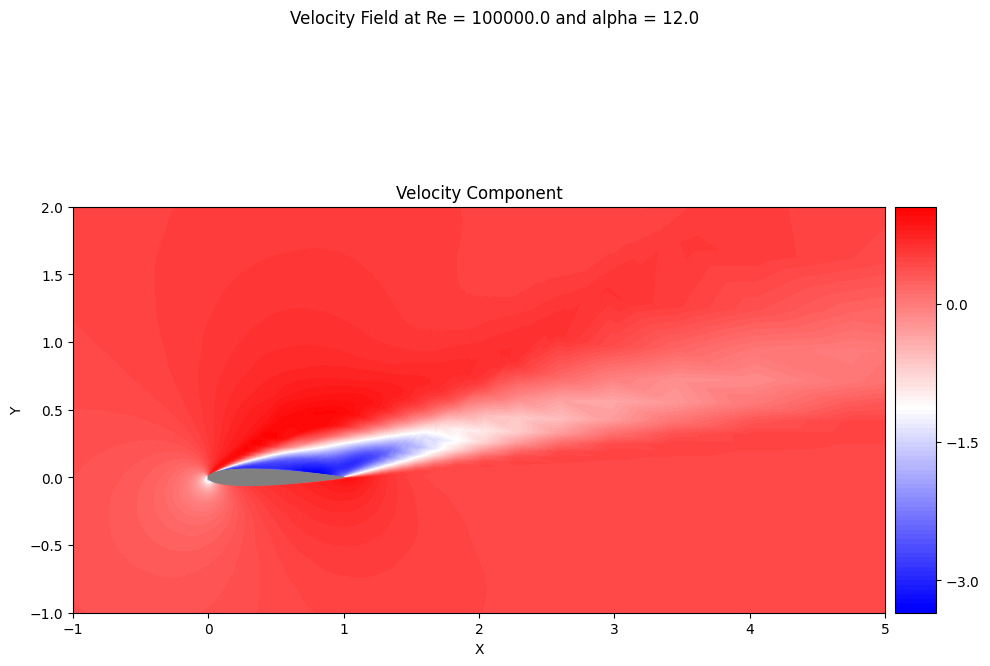

In [21]:
index = 18

test_plot_data = val_dataset[index].to(device)
test_param = test_plot_data.params

estimated_x, latent_variables, estimated_latent_variables = model(test_plot_data, test_param)
estimated_x = estimated_x.detach().cpu().numpy()

plot.plot_velocity_field(data=test_plot_data, title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", save=False, xlim=[-1, 5], ylim=[-1, 2], colormap='bwr')

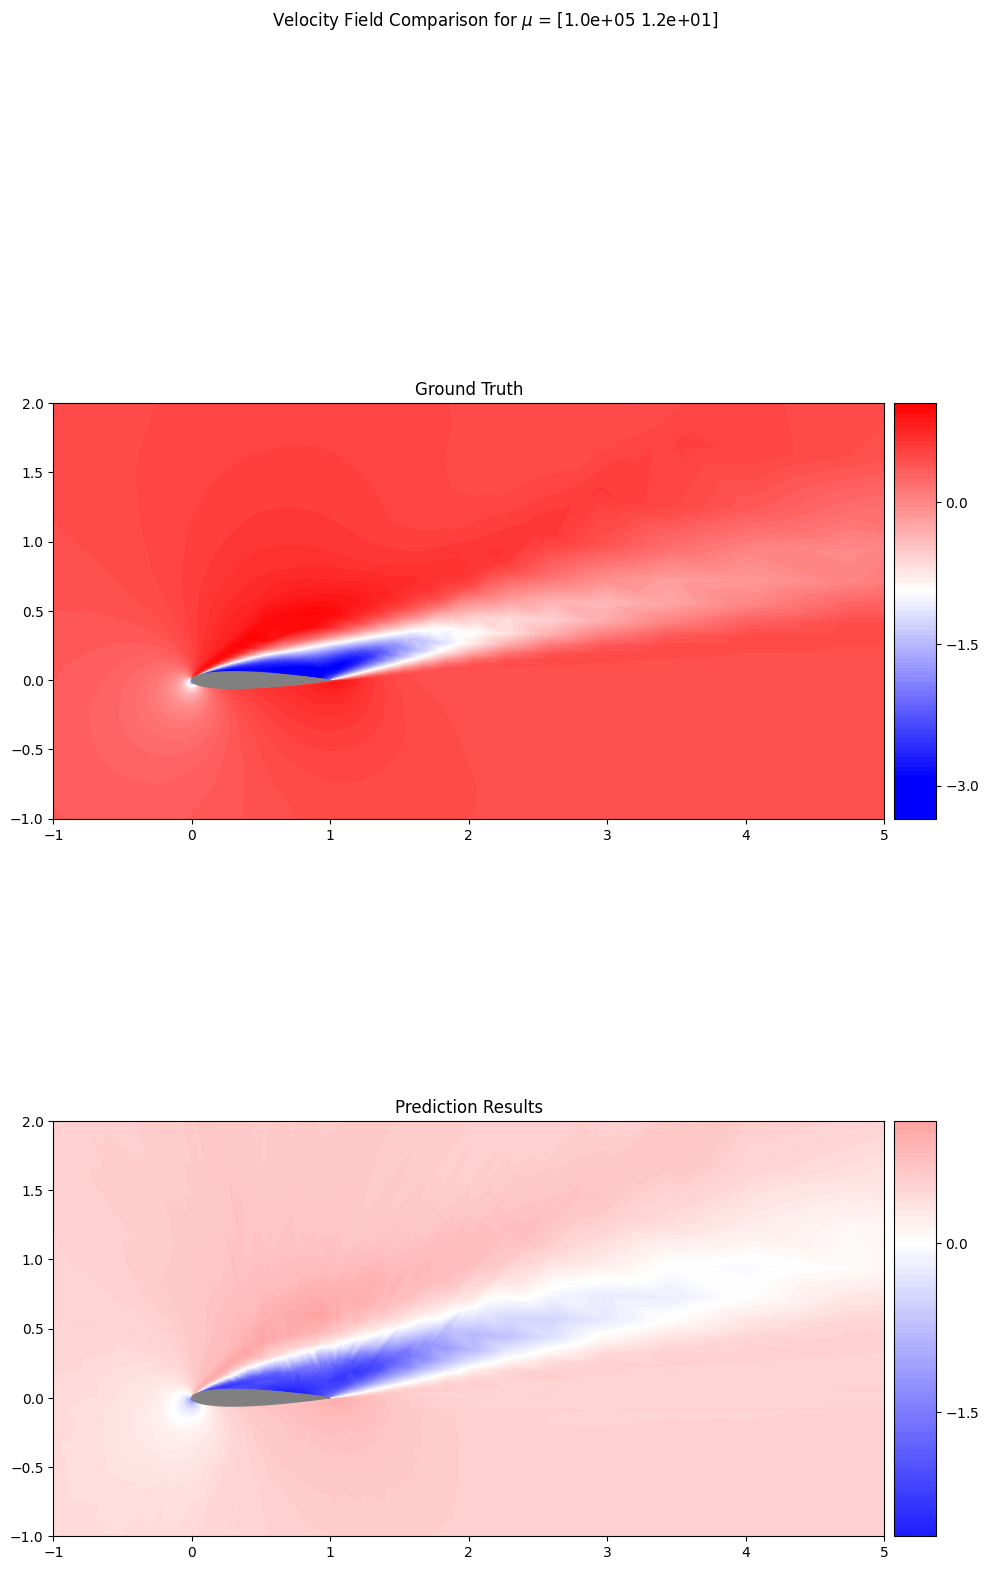

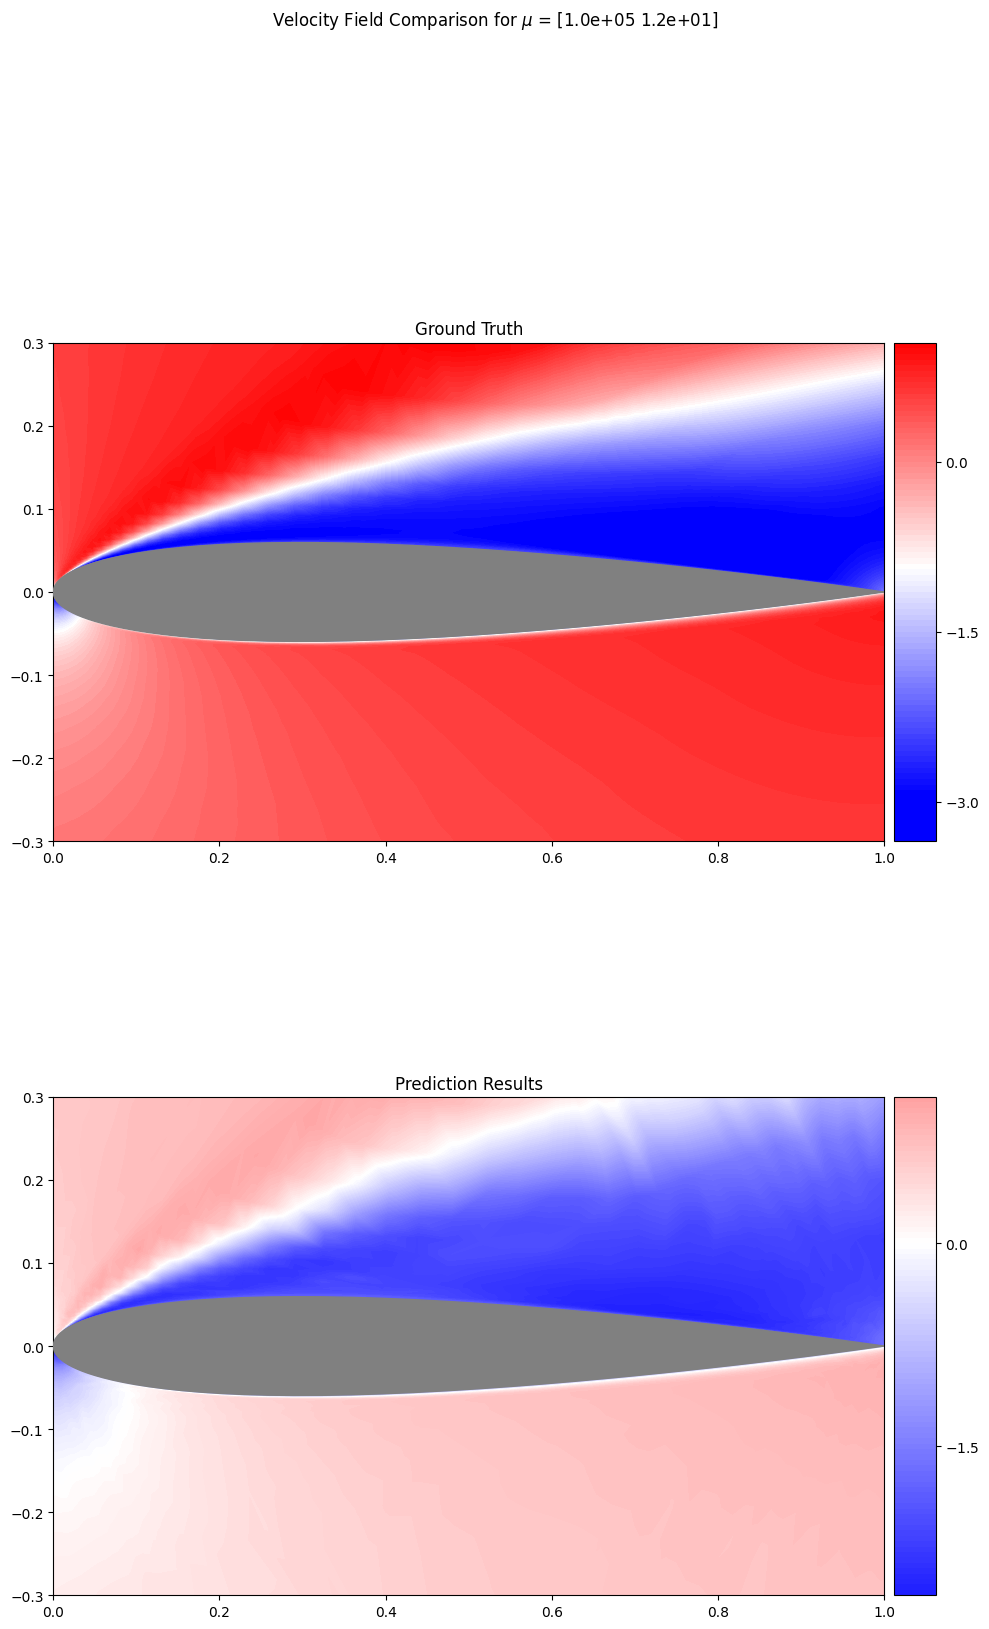

In [22]:
plot.plot_comparison_fields(SNAP = index, device = device, dataset = val_dataset, params = test_param, grid="vertical", colormap='bwr', xlim=[-1, 5], ylim=[-1, 2])

plot.plot_comparison_fields(SNAP = index, 
                            device = device,
                            dataset = val_dataset, 
                            params = test_param, grid="vertical", 
                            colormap='bwr', 
                            # xlim=[-1, 5], ylim=[-1, 2]
                            xlim=[0, 1], ylim=[-0.3, 0.3]
                            )

MSE Error

In [13]:
from torch.nn.functional import mse_loss

error= mse_loss(input=torch.tensor(estimated_x, device=test_plot_data.x.device), target=test_plot_data.x, reduction='mean')
print(f"Mean Squared Error: {error.item()}")

Mean Squared Error: 0.026288021355867386


v_range=[-0.17144335806369781, 0.17144335806369781]

dari v_rangenya volume

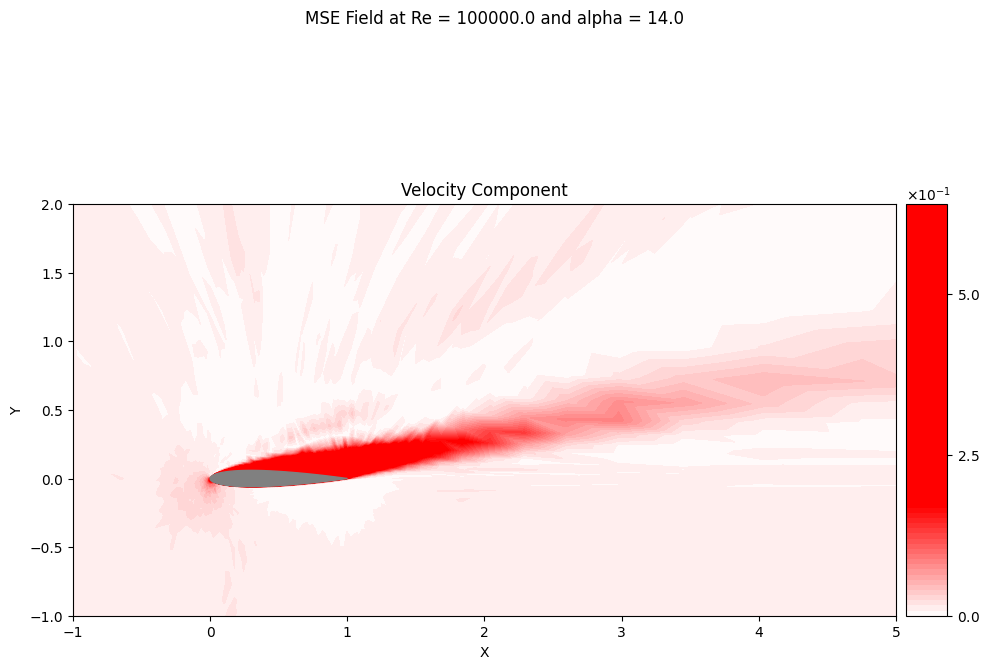

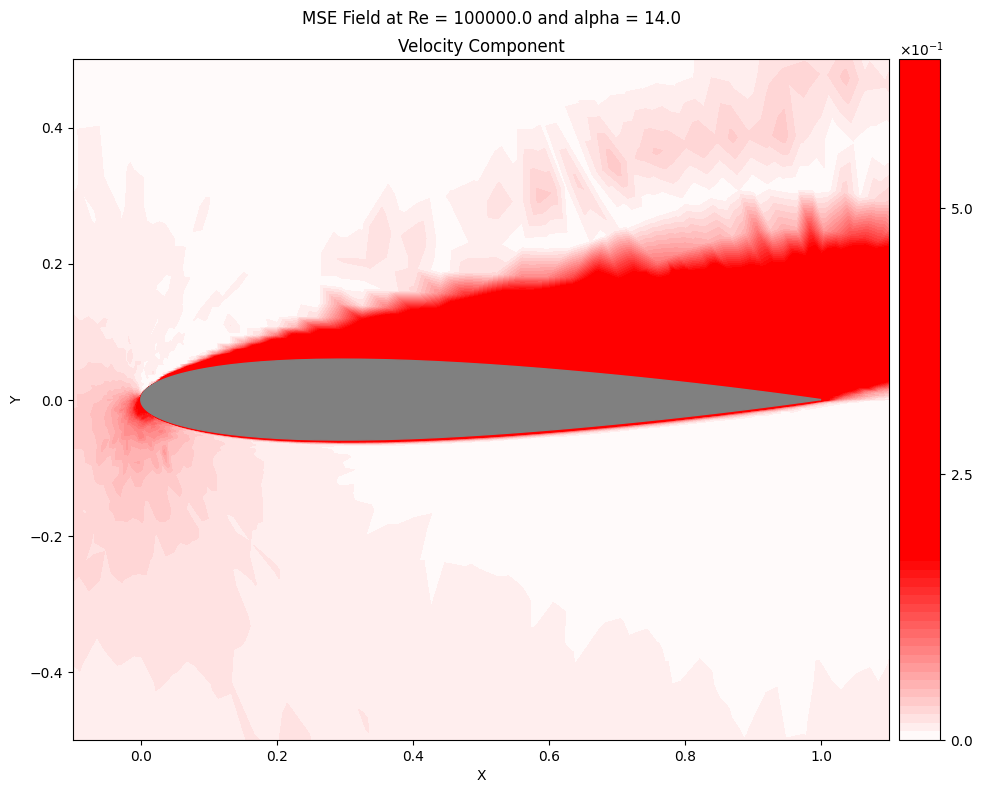

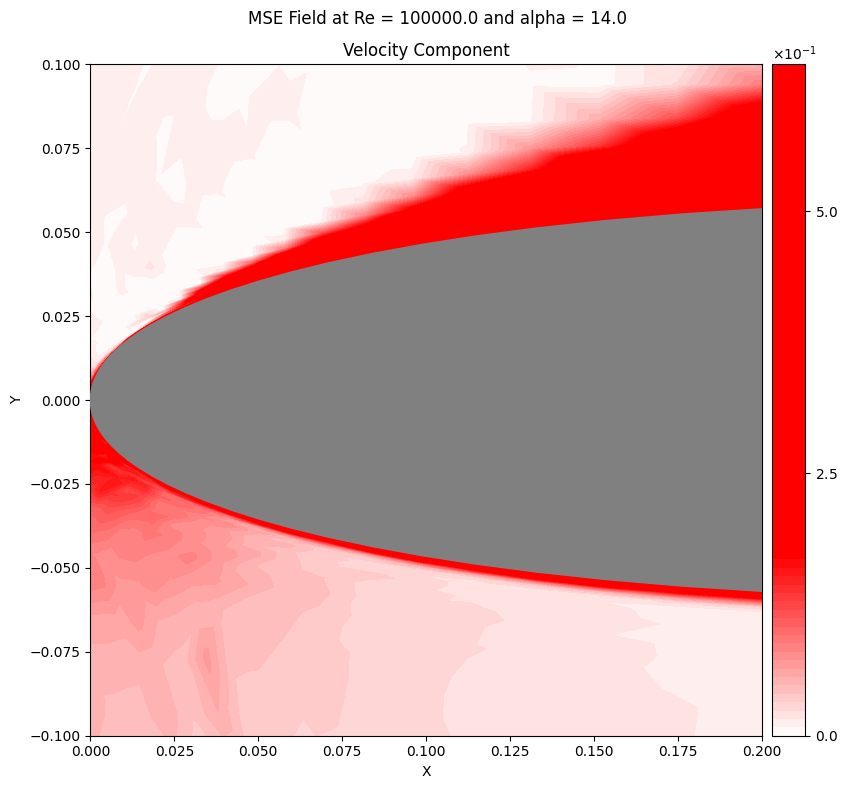

In [20]:
plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"MSE Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=[-0.17144335806369781, 0.17144335806369781],
                               xlim=[-1, 5], ylim=[-1, 2], 
                               colormap='bwr')

plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"MSE Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=[-0.17144335806369781, 0.17144335806369781],
                               xlim=[-0.1, 1.1], ylim=[-0.5, 0.5], 
                               colormap='bwr')

plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"MSE Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=[-0.17144335806369781, 0.17144335806369781],
                               xlim=[0, 0.2], ylim=[-0.1, 0.1], 
                               colormap='bwr')

# Modes

In [15]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.plot import Plot
from src.utils.commons import load_model
from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train_surface import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/X_NACA0012.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()
    
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']
surface_mask = val_dataset[100].x == 0
num_graphs = val_dataset.num_graphs
latent_dim_size = config['model']['autoencoder']['latent_dim']
model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, num_graphs=val_dataset.num_graphs)
model = model.to(device)

plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

for mode in range(1, latent_dim_size + 1):
    print(f"Mode {mode}")

    latent = torch.zeros((latent_dim_size,)).to(device)
    latent[mode - 1] = 1.0  # Set the first latent variable to 1.0

    test_data = val_dataset[0].to(device)
    decoded_x = model.linear_autoencoder.decoder(latent)
    test_data.x = model.graph_decoder(test_data, decoded_x)

    plot.plot_velocity_field(data=test_data, 
                            title=f"mode {mode}", 
                            save=False, xlim=[-1, 5], ylim=[-1, 2], colormap='bwr')

TypeError: load_model() got an unexpected keyword argument 'num_graphs'

# Pyvista

In [ ]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.plot import Plot
from src.utils.commons import load_model
from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train_surface import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/X_NACA0012.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()
    
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']
surface_mask = val_dataset[100].x == 0
num_graphs = val_dataset.num_graphs
latent_dim_size = config['model']['autoencoder']['latent_dim']
model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, num_graphs=val_dataset.num_graphs)
model = model.to(device)
model.eval()

mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)


mau make fizh ?
Iyaa. lu lg make kah?
Hmmm iya sih, bentar lagi deh, udah ngantuk bet juga wkwk
Oh ok2. gw nulis lg dlu kl gt
okee, ehh sama kalau gitu nvm hehe

In [ ]:
# test output

data = val_dataset[0].to(device)
val_trajectories = val_dataset.file_index[0]
params = torch.tensor(np.array(list(product(*[mu1, mu2]))))
params = params.to(device)
out_x,_,_ = model(data, params)

In [ ]:
import pyvista as pv

mesh_path = r"dataset/flows/configuration_1.vtu"
mesh = pv.read(mesh_path)

In [ ]:
mesh.point_data.clear()  # Optional: clear all previous scalars
mesh.point_data["Ux"] = out_x.detach().cpu().numpy()  # Replace or add new scalar "Utest.x
mesh

UnstructuredGrid (0x215d2c08fa0)
  N Cells:    14336
  N Points:   14576
  X Bounds:   -4.845e+02, 5.010e+02
  Y Bounds:   -5.078e+02, 5.078e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

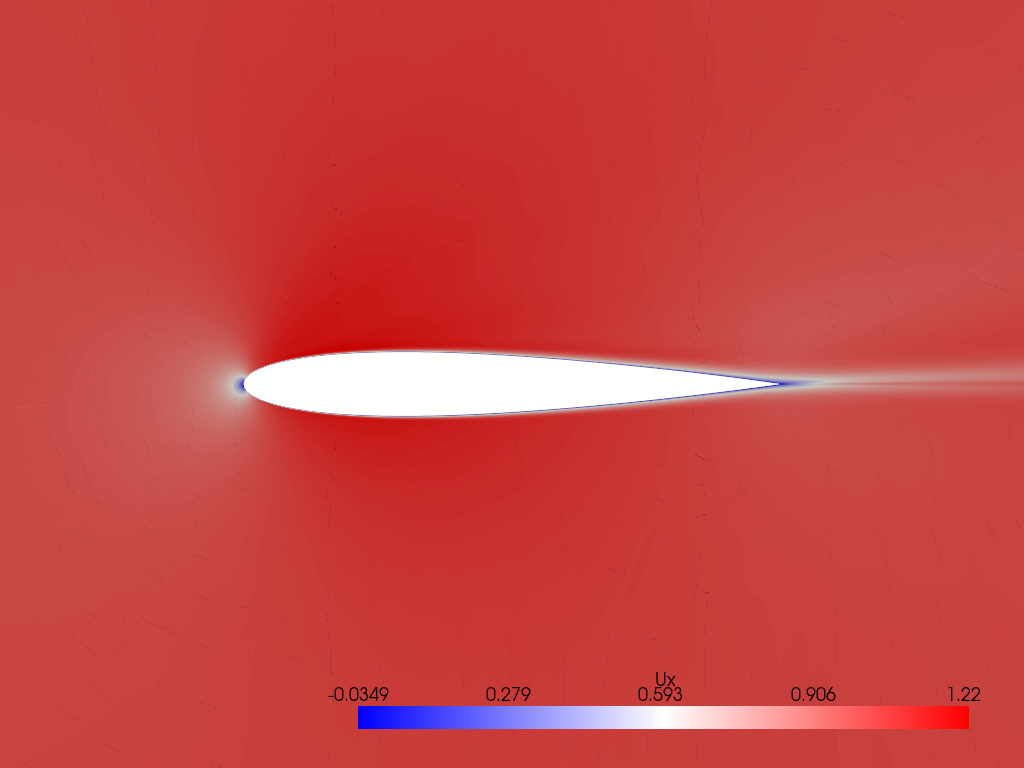

In [ ]:
plot = pv.Plotter()
plot.add_mesh(mesh, scalars="Ux", cmap="bwr", show_edges=False)
plot.view_xy()
plot.set_focus([0.5, 0, 0])
plot.camera.zoom(1000)
plot.show()